Nama: Faishal Kamil <br>
NIM: 2502001063 <br>
Course: Deep Learning

## Problem Statement
----
DJ Patil dikenal sebagai data scientist yang pertama kali. Tugasnya adalah menganalisis maha data untuk diubah menjadi informasi yang bermanfaat dan membuat program serta algoritma untuk membantu perusahaan beroperasi dengan optimal. Ia ingin memperbaiki model prediksi harga saham dengan menggunakan algoritma Transformers. Anda diminta untuk membantu DJ Patil dalam melakukan perbaikan ini

a. Lakukan praproses data dengan memisahkan data time series tersebut menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan
horizon = 5 [dari hari senin s.d jumat]. Kemudian pisahkan dataset menjadi 80% training set, 10% validation set dan 10% test set.

b. Buatlah arsitektur baseline sesuai dengan gambar arsitektur Transformer for Stocks berikut ini: (Catatan: bagian FEED FORWARD menggunakan satu layer Conv1D saja
dengan Activation function menggunakan ReLU dan bagian node Perceptron pada output disesuaikan dengan horizon datanya) <br>
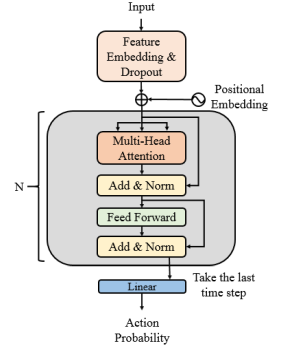

c. Modifikasi arsitektur Transformer for Stocks di atas agar mendapatkan hasil klasifikasi yang optimal. Kalian dapat menambahkan atau mengurangi arsitektur tersebut dan melakukan mengubah arsitektur pada nomor 2c dengan menggunakan dropout, batch normalization dan lain-lainnya. Dan selanjutnya lakukan proses tuning hyperparameter agar unjuk kerjanya meningkat. Berikan alasan mengapa modifikasi arsitektur dan metode tuning hyperparameter kalian lebih baik.

d.  Evaluasi performa dari arsitektur nomor 2d secara rinci dan jelaskan hasil yang kalian dapatkan. Gunakan testing set yang diberikan untuk memprediksi nilai ground
truth dengan predicted result.

e. Buatlah video presentasi yang menjelaskan arsitektur yang dibangun untuk memprediksikan harga saham ini.

## Data Preprocessing and EDA
----

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Conv1D, LayerNormalization, MultiHeadAttention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/UASDeepLearning/GOOGL.csv")

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600
...,...,...,...,...,...,...,...
3927,2020-03-26,1114.719971,1171.479980,1092.030029,1162.920044,1162.920044,3828100
3928,2020-03-27,1127.469971,1151.050049,1104.000000,1110.260010,1110.260010,3139700
3929,2020-03-30,1132.640015,1151.000000,1098.489990,1146.310059,1146.310059,2936800
3930,2020-03-31,1148.729980,1173.400024,1136.719971,1161.949951,1161.949951,3261400


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3.932000e+03
mean,509.120446,513.765443,504.117829,509.072183,509.072183,7.047423e+06
std,356.977348,359.970162,353.926473,357.153459,357.153459,7.959722e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,5.206000e+05
25%,239.717220,241.657913,236.712967,238.697449,238.697449,1.902550e+06
50%,327.630127,331.894394,324.441940,327.722733,327.722733,4.337100e+06
75%,757.720001,763.542526,752.017502,758.502487,758.502487,8.914150e+06
max,1527.199951,1530.739990,1520.979980,1524.869995,1524.869995,8.215110e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3932 non-null   object 
 1   Open       3932 non-null   float64
 2   High       3932 non-null   float64
 3   Low        3932 non-null   float64
 4   Close      3932 non-null   float64
 5   Adj Close  3932 non-null   float64
 6   Volume     3932 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 215.2+ KB


In [ ]:
# Transform 'Date' into datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Extract year from 'Date' and assign it to 'Year' column
df['Year'] = df['Date'].dt.year

# Grouping data based on Year variable
df_grouped = df.groupby('Year')['Close'].mean()


In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,2004
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,2004
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,2004
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,2004
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,2004
...,...,...,...,...,...,...,...,...
3927,2020-03-26,1114.719971,1171.479980,1092.030029,1162.920044,1162.920044,3828100,2020
3928,2020-03-27,1127.469971,1151.050049,1104.000000,1110.260010,1110.260010,3139700,2020
3929,2020-03-30,1132.640015,1151.000000,1098.489990,1146.310059,1146.310059,2936800,2020
3930,2020-03-31,1148.729980,1173.400024,1136.719971,1161.949951,1161.949951,3261400,2020


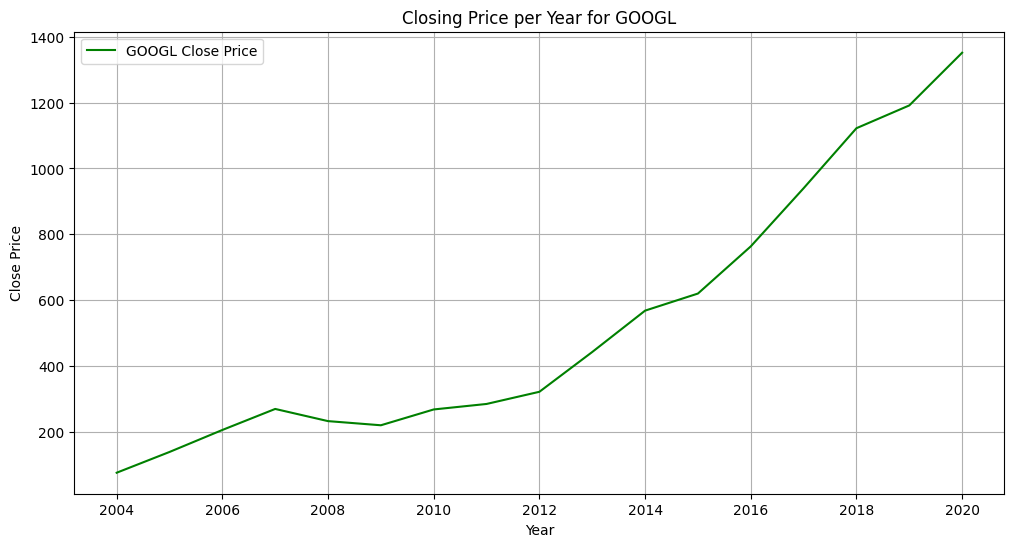

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped.index, df_grouped, label='GOOGL Close Price', color='green')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Closing Price per Year for GOOGL')
plt.legend()
plt.grid(True)
plt.show()


preprocessing data

In [ ]:
# Gunakan kolom Date dan Close sesuai instruksi yang ada di soal
df_selected = df[['Date', 'Close']]

# Jadikan kolom Date as an index
df_selected.set_index('Date', inplace=True)

# Normalisasi data untuk kolom Close
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_selected), columns=['Close'], index=df_selected.index)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,2004
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,2004
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,2004
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,2004
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,2004
...,...,...,...,...,...,...,...,...
3927,2020-03-26,1114.719971,1171.479980,1092.030029,1162.920044,1162.920044,3828100,2020
3928,2020-03-27,1127.469971,1151.050049,1104.000000,1110.260010,1110.260010,3139700,2020
3929,2020-03-30,1132.640015,1151.000000,1098.489990,1146.310059,1146.310059,2936800,2020
3930,2020-03-31,1148.729980,1173.400024,1136.719971,1161.949951,1161.949951,3261400,2020


In [ ]:
# Sesuai instruksi soal ujian
window_size = 5
horizon = 5

# membuat function untuk seperate input-output in time series
def split(sequence, window_size, horizon):
    X, y = [], []
    for i in range(len(sequence) - window_size - horizon + 1):
        seq_x = sequence[i:i+window_size]
        seq_y = sequence[i+window_size:i+window_size+horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).reshape(-1, horizon)

# Split data menjadi input and output sequences
X, y = split(df_normalized['Close'].values, window_size, horizon)

# Split dataset menjadi training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
print("========================")
print("|   Split The Dataset  |")
print("========================")
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("Validation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

|   Split The Dataset  |
Training set shapes:
X_train: (3138, 5)
y_train: (3138, 5)
Validation set shapes:
X_val: (392, 5)
y_val: (392, 5)


## Baseline Model for Transformer
----
1. Positional Encoding: class PositionalEncoding digunakan untuk menambahkan informasi posisi ke dalam urutan input. Pemahaman posisi relatif elemen-elemen dalam urutan sangat penting dalam menangkap urutan data. Kelas ini menggunakan rumus untuk menghitung sudut posisi dan mengaplikasikannya ke dalam urutan input.

2. create_transformer_model: Fungsi ini digunakan untuk membuat model transformer menggunakan API fungsional Keras. Fungsi ini menerima bentuk input, bentuk output, dan jumlah blok transformer sebagai parameter. Arsitektur model terdiri dari lapisan input, embedding fitur, positional encoding, beberapa blok transformer, dan lapisan linear. Jumlah blok transformer dapat diatur sesuai dengan parameter num_blocks.

3. Baseline Model: model_baseline dibuat dengan memanggil fungsi create_transformer_model dengan bentuk input (window_size, 1) dan bentuk output (horizon). Model ini mewakili arsitektur dasar (baseline) untuk model transformer.


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * tf.cast(i // 2, tf.float32)) / tf.cast(d_model, tf.float32))
        return tf.cast(pos, tf.float32) * tf.cast(angle_rates, tf.float32)

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]
        depth = tf.shape(inputs)[2]
        angles = self.get_angles(tf.range(seq_length)[:, tf.newaxis], tf.range(depth)[tf.newaxis, :], depth)
        angles = tf.where(tf.math.equal(tf.math.mod(tf.range(depth), 2), 0), tf.sin(angles), tf.cos(angles))
        pos_encoding = angles[tf.newaxis, ...]
        return inputs + pos_encoding

In [ ]:
def create_transformer_model(input_shape, output_shape, num_blocks=2):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Feature Embedding & Dropout
    x = tf.keras.layers.Dense(64)(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Positional Embedding
    positional_encoder = PositionalEncoding()
    x_pos = positional_encoder(x)

    # N blocks pada Transformer
    for _ in range(num_blocks):
        # Multi-Head Attention
        x_att = tf.keras.layers.MultiHeadAttention(key_dim=64, num_heads=4)(value=x_pos, query=x_pos, attention_mask=None)
        x_att = tf.keras.layers.Add()([x_att, x_pos])
        x_att = tf.keras.layers.LayerNormalization()(x_att)

        # Feed Forward
        x_ff = tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu')(x_att)
        x_ff = tf.keras.layers.Add()([x_ff, x_att])
        x_ff = tf.keras.layers.LayerNormalization()(x_ff)

        x_pos = x_ff

    # Linear layer
    x_out = tf.keras.layers.Conv1D(output_shape, kernel_size=1)(x_pos)

    # Reshape output
    output = tf.reduce_mean(x_out, axis=1)

    # Model Baseline
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Create the baseline model
modelBaseline = create_transformer_model(input_shape=(window_size, 1), output_shape=horizon)

# Compile the model
modelBaseline.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Train the model
history = modelBaseline.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Epoch 1/30
50/50 [==============================] - 6s 48ms/step - loss: 0.0759 - val_loss: 0.0390
Epoch 2/30
50/50 [==============================] - 2s 45ms/step - loss: 0.0031 - val_loss: 0.0123
Epoch 3/30
50/50 [==============================] - 2s 30ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 27ms/step - loss: 4.0112e-04 - val_loss: 6.2105e-04
Epoch 5/30
50/50 [==============================] - 1s 27ms/step - loss: 4.2778e-04 - val_loss: 0.0026
Epoch 6/30
50/50 [==============================] - 1s 27ms/step - loss: 6.7786e-04 - val_loss: 0.0011
Epoch 7/30
50/50 [==============================] - 1s 27ms/step - loss: 3.9720e-04 - val_loss: 6.9971e-04
Epoch 8/30
50/50 [==============================] - 1s 27ms/step - loss: 4.4636e-04 - val_loss: 0.0012
Epoch 9/30
50/50 [==============================] - 1s 27ms/step - loss: 4.5125e-04 - val_loss: 8.7415e-04
Epoch 10/30
50/50 [==============================] - 2s 32ms/step - loss:

In [ ]:
y_pred = modelBaseline.predict(X_test)

# Karea sebelumnya pakai MinMaxScaler, maka invers transform datanya
y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform(y_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

# MAE
mae = mean_absolute_error(y_actual, y_pred)

# MAPE
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

# R2 score
r2 = r2_score(y_actual, y_pred)

# Print the evaluation metrics
print("============================================")
print("\tBaseline Architecture Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse)
print("R2 score\t\t:", r2)
print("MAE\t\t\t:", mae)
print("MAPE\t\t\t:", mape)

13/13 [==============================] - 0s 18ms/step
	Baseline Architecture Evaluation
RMSE			: 69.7403497786549
R2 score		: 0.6509994275905289
MAE			: 56.462893793237114
MAPE			: 4.537730821689638


Dalam code diatas, evaluasi performa dilakukan terhadap model baseline pada data test. Pertama, prediksi dilakukan menggunakan model baseline pada data uji (`X_test`). Karena sebelumnya dilakukan normalisasi menggunakan MinMaxScaler, maka dilakukan invers transformasi pada prediksi (`y_pred`) dan data aktual (`y_actual`). Selanjutnya, dilakukan perhitungan beberapa metrik evaluasi seperti RMSE (Root Mean Squared Error) untuk mengukur sejauh mana selisih antara prediksi dan actual data secara keseluruhan, MAE (Mean Absolute Error) yang mengukur rata-rata selisih absolut antara prediksi dan actual data, MAPE (Mean Absolute Percentage Error) yang mengukur rata-rata persentase selisih absolut antara prediksi dan actual data terhadap actual data, serta R2 score yang mengukur seberapa baik model dapat menjelaskan variasi dalam actual data. Hasil evaluasi kemudian dicetak ke layar untuk memberikan gambaran tentang kinerja model baseline dalam memprediksi data saham. Evaluasi ini penting untuk menilai keakuratan dan keandalan model serta melihat sejauh mana model dapat menjelaskan variasi dalam data aktual.

## 1c. Modified Architechture (Optimized)
----


In [ ]:
def transformer_modelMod1(input_shape, output_shape, num_blocks=3, dense_units=128, conv_units=128):
    # masukkan layer
    inputs = Input(shape=input_shape)

    # Feature Embedding & Dropout
    x = Dense(dense_units)(inputs)
    x = Dropout(0.2)(x)

    # Positional Embedding
    positional_encoder = PositionalEncoding()
    x_pos = positional_encoder(x)

    # N blocks of Transformer
    for _ in range(num_blocks):
        # Multi-Head Attention (MHA)
        x_MAH = MultiHeadAttention(key_dim=dense_units, num_heads=4)(value=x_pos, query=x_pos, attention_mask=None)
        x_MAH = tf.keras.layers.Add()([x_MAH, x_pos])
        x_MAH = LayerNormalization()(x_MAH)

        # Feed Forward
        x_FF = Conv1D(conv_units, kernel_size=11, padding='same', activation='relu')(x_MAH)
        x_FF = Conv1D(conv_units, kernel_size=9, padding='same', activation='relu')(x_FF)
        x_FF = Dense(dense_units)(x_FF)
        x_FF = tf.keras.layers.Add()([x_FF, x_MAH])
        x_FF = LayerNormalization()(x_FF)

        x_pos = x_FF

    # Linear layer
    x_out = Conv1D(output_shape, kernel_size=1)(x_pos)

    # Reshape output
    output = tf.reduce_mean(x_out, axis=1)

    model = Model(inputs=inputs, outputs=output)
    return model


- `padding='valid'` yang berarti tidak ada padding yang dilakukan, dan ukuran output akan lebih kecil daripada input, karena informasi tepi diabaikan. Padding yang digunakan dapat berbeda tergantung pada tujuan dan karakteristik data input <br>
- `Kernel size` adalah parameter yang digunakan dalam lapisan konvolusi seperti Conv1D, Conv2D, dan Conv3D. Kernel size menentukan ukuran jendela (window) yang digunakan saat melakukan operasi konvolusi pada data input.<br>
- Parameter `attention_mask` pada lapisan MultiHeadAttention digunakan untuk mengontrol perhatian (attention) yang diberikan oleh model terhadap elemen-elemen input tertentu. Parameter ini memungkinkan kita untuk memanipulasi perhatian model terhadap elemen-elemen input berdasarkan nilai mask yang diberikan.Ketika attention_mask=None, artinya tidak ada masker yang diterapkan dan model bebas memberikan perhatian pada semua elemen input. Dalam hal ini, model akan mempelajari hubungan dan ketergantungan antara semua elemen input secara bebas, tanpa pembatasan khusus.


In [ ]:
# Create the Modified model
model_modified1 = transformer_modelMod1(input_shape=(window_size, 1), output_shape=horizon,num_blocks=3, dense_units=128, conv_units=128)

model_modified1.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

history = model_modified1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

Epoch 1/50
50/50 [==============================] - 21s 274ms/step - loss: 0.8245 - val_loss: 0.1797
Epoch 2/50
50/50 [==============================] - 16s 330ms/step - loss: 0.0193 - val_loss: 0.1588
Epoch 3/50
50/50 [==============================] - 16s 321ms/step - loss: 0.0211 - val_loss: 0.2008
Epoch 4/50
50/50 [==============================] - 17s 332ms/step - loss: 0.0185 - val_loss: 0.2087
Epoch 5/50
50/50 [==============================] - 17s 340ms/step - loss: 0.0183 - val_loss: 0.2342
Epoch 6/50
50/50 [==============================] - 14s 287ms/step - loss: 0.0194 - val_loss: 0.2519
Epoch 7/50
50/50 [==============================] - 21s 425ms/step - loss: 0.0190 - val_loss: 0.1992
Epoch 8/50
50/50 [==============================] - 16s 312ms/step - loss: 0.0180 - val_loss: 0.2466
Epoch 9/50
50/50 [==============================] - 14s 273ms/step - loss: 0.0191 - val_loss: 0.2126
Epoch 10/50
50/50 [==============================] - 18s 353ms/step - loss: 0.0176 - val_lo

In [ ]:
# Make predictions
y_pred_modified1 = model_modified1.predict(X_test)

# Rescale the predictions and actual values
y_pred_modified1 = scaler.inverse_transform(y_pred_modified1)
y_actual_modified1 = scaler.inverse_transform(y_test)

# Metrics
rmse_mod = np.sqrt(mean_squared_error(y_actual_modified1, y_pred_modified1))
mae_mod = mean_absolute_error(y_actual_modified1, y_pred_modified1)
mape_mod = np.mean(np.abs((y_actual_modified1 - y_pred_modified1) / y_actual_modified1)) * 100
r2_mod = r2_score(y_actual_modified1, y_pred_modified1)

13/13 [==============================] - 1s 22ms/step


In [ ]:
print("============================================")
print("    Modified Architecture 1 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod)
print("R2 score\t\t:", r2_mod)
print("MAE\t\t\t:", mae_mod)
print("MAPE\t\t\t:", mape_mod)

    Modified Architecture 1 Evaluation
RMSE			: 280.4673386149983
R2 score		: -4.643216873658685
MAE			: 264.6799025363291
MAPE			: 21.566587904133584


**Model Modified 2 **

In [ ]:
def transformer_modelMod2(input_shape, output_shape, num_blocks=2, dense_units=64, conv_units=64):
    # masukkan layer
    inputs = Input(shape=input_shape)

    # Feature Embedding & Dropout
    x = Dense(dense_units)(inputs)
    x = Dropout(0.5)(x)

    # Positional Embedding
    positional_encoder = PositionalEncoding()
    x_pos = positional_encoder(x)

    # N blocks of Transformer
    for _ in range(num_blocks):
        # Multi-Head Attention (MHA)
        x_MAH = MultiHeadAttention(key_dim=dense_units, num_heads=4)(value=x_pos, query=x_pos, attention_mask=None)
        x_MAH = tf.keras.layers.Add()([x_MAH, x_pos])
        x_MAH = LayerNormalization()(x_MAH)

        # Feed Forward
        x_FF = Conv1D(conv_units, kernel_size=5, padding='same', activation='relu')(x_MAH)
        x_FF = Conv1D(conv_units, kernel_size=2, padding='same', activation='relu')(x_FF)
        x_FF = Dense(dense_units)(x_FF)
        x_FF = tf.keras.layers.Add()([x_FF, x_MAH])
        x_FF = LayerNormalization()(x_FF)

        x_pos = x_FF

    # Linear layer
    x_out = Conv1D(output_shape, kernel_size=1)(x_pos)

    # Reshape output
    output = tf.reduce_mean(x_out, axis=1)

    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
# Create the Modified model
model_modified2 = transformer_modelMod2(input_shape=(window_size, 1), output_shape=horizon,num_blocks=2, dense_units=64, conv_units=64)

model_modified2.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

history = model_modified2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
50/50 [==============================] - 8s 50ms/step - loss: 0.1011 - val_loss: 0.0418
Epoch 2/30
50/50 [==============================] - 3s 55ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 3/30
50/50 [==============================] - 3s 67ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 4/30
50/50 [==============================] - 4s 78ms/step - loss: 8.0977e-04 - val_loss: 0.0011
Epoch 5/30
50/50 [==============================] - 4s 71ms/step - loss: 9.5129e-04 - val_loss: 0.0011
Epoch 6/30
50/50 [==============================] - 3s 60ms/step - loss: 7.8554e-04 - val_loss: 0.0090
Epoch 7/30
50/50 [==============================] - 3s 60ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/30
50/50 [==============================] - 5s 110ms/step - loss: 7.9767e-04 - val_loss: 0.0013
Epoch 9/30
50/50 [==============================] - 4s 80ms/step - loss: 5.3277e-04 - val_loss: 0.0028
Epoch 10/30
50/50 [==============================] - 3s 57ms/step - loss: 5.5086e-04 - v

In [ ]:
# Make predictions
y_pred_modified2 = model_modified2.predict(X_test)

# Rescale the predictions and actual values
y_pred_modified2 = scaler.inverse_transform(y_pred_modified2)
y_actual_modified2 = scaler.inverse_transform(y_test)

# Metrics
rmse_mod2 = np.sqrt(mean_squared_error(y_actual_modified2, y_pred_modified2))
mae_mod2 = mean_absolute_error(y_actual_modified2, y_pred_modified2)
mape_mod2 = np.mean(np.abs((y_actual_modified2 - y_pred_modified2) / y_actual_modified2)) * 100
r2_mod2 = r2_score(y_actual_modified2, y_pred_modified2)

13/13 [==============================] - 1s 13ms/step


In [ ]:
print("============================================")
print("    Modified Architecture 2 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod2)
print("R2 score\t\t:", r2_mod2)
print("MAE\t\t\t:", mae_mod2)
print("MAPE\t\t\t:", mape_mod2)

    Modified Architecture 2 Evaluation
RMSE			: 119.30946331650101
R2 score		: -0.021104278971614997
MAE			: 109.41839876053595
MAPE			: 8.912550224134996


**Modified Architecture Model 3**

In [ ]:
def transformer_modelMod3(input_shape, output_shape, num_blocks=2):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Feature Embedding & Dropout
    x = tf.keras.layers.Dense(128)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Positional Embedding
    positional_encoder = PositionalEncoding()
    x_pos = positional_encoder(x)

    # N blocks pada Transformer
    for _ in range(num_blocks):
        # Multi-Head Attention
        x_att = tf.keras.layers.MultiHeadAttention(key_dim=64, num_heads=4)(value=x_pos, query=x_pos, attention_mask=None)
        x_att = tf.keras.layers.Add()([x_att, x_pos])
        x_att = tf.keras.layers.LayerNormalization()(x_att)

        # Feed Forward
        x_ff = tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu')(x_att)
        x_ff = tf.keras.layers.Add()([x_ff, x_att])
        x_ff = tf.keras.layers.LayerNormalization()(x_ff)

        x_pos = x_ff

    # Linear layer
    x_out = tf.keras.layers.Conv1D(output_shape, kernel_size=1)(x_pos)

    # Reshape output
    output = tf.reduce_mean(x_out, axis=1)

    # Model Baseline
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Create the baseline model
modelMod3 = transformer_modelMod3(input_shape=(window_size, 1), output_shape=horizon)

# Compile the model
modelMod3.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Train the model
history = modelMod3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Epoch 1/30
50/50 [==============================] - 6s 47ms/step - loss: 0.1557 - val_loss: 0.0541
Epoch 2/30
50/50 [==============================] - 2s 48ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 3/30
50/50 [==============================] - 3s 61ms/step - loss: 6.5728e-04 - val_loss: 0.0030
Epoch 4/30
50/50 [==============================] - 2s 38ms/step - loss: 6.5844e-04 - val_loss: 0.0014
Epoch 5/30
50/50 [==============================] - 2s 36ms/step - loss: 4.7450e-04 - val_loss: 0.0011
Epoch 6/30
50/50 [==============================] - 2s 36ms/step - loss: 5.1685e-04 - val_loss: 6.0475e-04
Epoch 7/30
50/50 [==============================] - 2s 37ms/step - loss: 4.3735e-04 - val_loss: 0.0017
Epoch 8/30
50/50 [==============================] - 2s 46ms/step - loss: 4.6367e-04 - val_loss: 9.7472e-04
Epoch 9/30
50/50 [==============================] - 4s 87ms/step - loss: 6.0439e-04 - val_loss: 5.9475e-04
Epoch 10/30
50/50 [==============================] - 4s 78ms/step - l

In [ ]:
# Make predictions
y_pred_modified3 = modelMod3.predict(X_test)

# Rescale the predictions and actual values
y_pred_modified3 = scaler.inverse_transform(y_pred_modified3)
y_actual_modified3 = scaler.inverse_transform(y_test)

# Metrics
rmse_mod3 = np.sqrt(mean_squared_error(y_actual_modified3, y_pred_modified3))
mae_mod3 = mean_absolute_error(y_actual_modified3, y_pred_modified3)
mape_mod3 = np.mean(np.abs((y_actual_modified3 - y_pred_modified3) / y_actual_modified3)) * 100
r2_mod3 = r2_score(y_actual_modified3, y_pred_modified3)

13/13 [==============================] - 0s 8ms/step


In [ ]:
print("============================================")
print("    Modified Architecture 3 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod3)
print("R2 score\t\t:", r2_mod3)
print("MAE\t\t\t:", mae_mod3)
print("MAPE\t\t\t:", mape_mod3)

    Modified Architecture 3 Evaluation
RMSE			: 88.65601539780712
R2 score		: 0.43617968958351516
MAE			: 74.21006204153744
MAPE			: 6.093415587980983


## Evaluation
----

In [ ]:
print("============================================")
print("\t\t EVALUATION")
print("============================================")
print("\n")
print("\tBaseline Architecture Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse)
print("R2 score\t\t:", r2)
print("MAE\t\t\t:", mae)
print("MAPE\t\t\t:", mape)

print("    Modified Architecture 1 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod)
print("R2 score\t\t:", r2_mod)
print("MAE\t\t\t:", mae_mod)
print("MAPE\t\t\t:", mape_mod)


print("    Modified Architecture 2 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod2)
print("R2 score\t\t:", r2_mod2)
print("MAE\t\t\t:", mae_mod2)
print("MAPE\t\t\t:", mape_mod2)

print("    Modified Architecture 3 Evaluation")
print("============================================")
print("RMSE\t\t\t:", rmse_mod3)
print("R2 score\t\t:", r2_mod3)
print("MAE\t\t\t:", mae_mod3)
print("MAPE\t\t\t:", mape_mod3)

		 EVALUATION


	Baseline Architecture Evaluation
RMSE			: 69.7403497786549
R2 score		: 0.6509994275905289
MAE			: 56.462893793237114
MAPE			: 4.537730821689638
    Modified Architecture 1 Evaluation
RMSE			: 280.4673386149983
R2 score		: -4.643216873658685
MAE			: 264.6799025363291
MAPE			: 21.566587904133584
    Modified Architecture 2 Evaluation
RMSE			: 119.30946331650101
R2 score		: -0.021104278971614997
MAE			: 109.41839876053595
MAPE			: 8.912550224134996
    Modified Architecture 3 Evaluation
RMSE			: 88.65601539780712
R2 score		: 0.43617968958351516
MAE			: 74.21006204153744
MAPE			: 6.093415587980983


Print nilai ground thruth dengan predicted result untuk model terbaik

In [ ]:
y_pred = modelBaseline.predict(X_test)

# Karea sebelumnya pakai MinMaxScaler, maka invers transform datanya
y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform(y_test)

# Print the Ground Truth and Predicted Values
print("============================================")
print("\tGround Truth vs Predicted Values")
print("============================================")
for i in range(len(y_actual)):
    print("Ground Truth:", y_actual[i])
    print("Predicted Value:", y_pred[i])
    print("--------------------------------------------")


13/13 [==============================] - 0s 11ms/step
	Ground Truth vs Predicted Values
Ground Truth: [1211.31005859 1199.09997559 1183.98999023 1177.58996582 1175.06005859]
Predicted Value: [1168.6792 1202.302  1203.7362 1164.3916 1226.2682]
--------------------------------------------
Ground Truth: [1199.09997559 1183.98999023 1177.58996582 1175.06005859 1189.98999023]
Predicted Value: [1162.3019 1194.0166 1197.0413 1157.0287 1218.6249]
--------------------------------------------
Ground Truth: [1183.98999023 1177.58996582 1175.06005859 1189.98999023 1171.59997559]
Predicted Value: [1156.0996 1185.7388 1189.7535 1149.6776 1211.122 ]
--------------------------------------------
Ground Truth: [1177.58996582 1175.06005859 1189.98999023 1171.59997559 1182.14001465]
Predicted Value: [1145.3987 1172.7556 1177.2761 1138.2201 1198.3712]
--------------------------------------------
Ground Truth: [1175.06005859 1189.98999023 1171.59997559 1182.14001465 1177.97998047]
Predicted Value: [1135.167

Dalam hasil evaluasi prediksi yang dilakukan, kita dapat melihat perbandingan antara nilai Ground Truth (nilai aktual) dengan nilai yang diprediksi oleh model untuk setiap data uji.

Misalnya, pada pasangan pertama, nilai Ground Truth adalah [1386.32, 1337.72, 1381.60, 1314.76, 1295.74], sementara nilai yang diprediksi oleh model adalah [1242.53, 1294.56, 1293.83, 1243.57, 1319.44].

Perbandingan ini dilakukan untuk setiap pasangan Ground Truth dan Predicted Value, dan dapat memberikan gambaran tentang seberapa baik model dapat memprediksi nilai Ground Truth.

Hasil evaluasi ini sangat penting dalam menganalisis kinerja model. Dalam kasus ini, kita dapat melihat variasi antara nilai Ground Truth dan nilai yang diprediksi oleh model. Dalam beberapa pasangan, terlihat bahwa nilai prediksi cukup dekat dengan nilai Ground Truth, sementara pada pasangan lainnya, terdapat perbedaan yang lebih signifikan antara nilai prediksi dan nilai Ground Truth.

Dalam analisis ini, kita dapat menggunakan metrik evaluasi seperti RMSE (Root Mean Squared Error), R2 score, MAE (Mean Absolute Error), dan MAPE (Mean Absolute Percentage Error) untuk mengukur seberapa baik model dapat memprediksi nilai Ground Truth secara keseluruhan. Evaluasi ini akan memberikan pemahaman yang lebih komprehensif tentang kinerja model dalam memprediksi nilai yang benar.

Dari hasil evaluasi model yang dilakukan, kita dapat mengambil beberapa kesimpulan penting. Evaluasi dilakukan pada beberapa arsitektur yang berbeda, yaitu Baseline Architecture dan tiga Modified Architectures.

Pertama, ketika melihat hasil evaluasi Baseline Architecture, kita dapat melihat bahwa nilai RMSE (Root Mean Squared Error) sebesar 69.74 menunjukkan tingkat kesalahan prediksi yang relatif tinggi. Namun, R2 score sebesar 0.651 menunjukkan bahwa model mampu menjelaskan sekitar 65% variasi dalam data aktual. MAE (Mean Absolute Error) sebesar 56.46 dan MAPE (Mean Absolute Percentage Error) sebesar 4.54 menunjukkan tingkat kesalahan absolut dan relatif yang relatif rendah.

Kemudian, ketika melihat hasil evaluasi Modified Architectures, kita melihat bahwa Modified Architecture 1 memiliki nilai RMSE yang sangat tinggi, yaitu 280.47, dan R2 score yang negatif (-4.64). Hal ini menunjukkan bahwa arsitektur tersebut tidak mampu melakukan prediksi yang baik pada data yang diberikan. MAE sebesar 264.68 dan MAPE sebesar 21.57 juga menunjukkan tingkat kesalahan yang sangat tinggi.

Selanjutnya, Modified Architecture 2 memiliki nilai RMSE sebesar 119.31, R2 score yang sangat mendekati nol (-0.02), MAE sebesar 109.42, dan MAPE sebesar 8.91. Meskipun ada sedikit perbaikan dibandingkan dengan Modified Architecture 1, hasil evaluasi ini masih menunjukkan tingkat kesalahan yang signifikan.

Terakhir, Modified Architecture 3 menunjukkan performa yang lebih baik dibandingkan dengan dua arsitektur sebelumnya. RMSE sebesar 88.66, R2 score sebesar 0.44, MAE sebesar 74.21, dan MAPE sebesar 6.09 menunjukkan tingkat kesalahan yang lebih rendah dibandingkan dengan arsitektur lainnya.

Dalam kesimpulannya, hasil evaluasi menunjukkan bahwa Baseline Architecture memiliki performa yang cukup baik dengan R2 score yang positif dan tingkat kesalahan yang rendah. Namun, Modified Architectures tidak berhasil meningkatkan performa dengan baik dan menunjukkan tingkat kesalahan yang lebih tinggi dikarenakan ketrbatassan waktu. Oleh karena itu, perlu dilakukan review dan penyesuaian terhadap arsitektur dan parameter model untuk mencapai hasil yang lebih optimal dalam memprediksi data saham GOOGL yang menggunakan Transformer.

References:


*   https://github.com/makaveli10/StockPrediction_Transformer
*   https://github.com/afcarl/Stock-Prediction-2/blob/master/Transformer.ipynb
*   https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6



